This function is usefull for displaying multiple variables related to a polygon in a choropleth map way. Standard visualisations for this sort of data is displaying a [histogram inside the polygon](https://desktop.arcgis.com/en/arcmap/10.3/map/working-with-layers/using-bar-and-column-charts.htm), which i'm not really keen on how it looks. Instead, the polygons are proportionally segmented based on the attributes provided. A disadvantage is that the scale of values gets normalised between 0-1 which may or may not be desired. Anyway here's how it goes:

In [1]:
from shapely import geometry
from descartes import PolygonPatch
import geopandas as gpd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

%matplotlib inline


In [2]:

#### Load the file containing the geometry. We use London's output areas here
poly = gpd.read_file('data\\OA_2011.shp', crs = {'init': 'espg:4326'})

#### Load the file containing the attributes. This will be some labour statistics
eating = pd.read_csv('data\\eat_QS605EW0017_OA.csv')
eating.rename({'QS605EW0001 (base)': 'eat_lu'}, axis='columns', inplace=True)
poly = pd.merge( poly, eating.reset_index(), right_on='index', left_on='OA11CD')

health = pd.read_csv('data\\health_QS605EW0025_OA.csv')
health.rename({'QS605EW0001 (base)': 'health_lu'}, axis='columns', inplace=True)
poly = pd.merge(poly, health.reset_index(), right_on='index', left_on='OA11CD')

education = pd.read_csv('data\\education_QS605EW0024_OA.csv')
education.rename({'QS605EW0001 (base)': 'edu_lu'},axis='columns', inplace=True)
poly = pd.merge(poly, education.reset_index(), right_on='index', left_on='OA11CD')

leisure = pd.read_csv('data\\leisure_QS606EW0086_OA.csv')
leisure.rename({'QS606EW0001 (base)': 'leisure_lu'},axis='columns', inplace=True)
poly = pd.merge(poly, leisure.reset_index(), right_on='index', left_on='OA11CD')




In [3]:
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']

def plot_map(data, attributes):
    ### Calculate the proportions
    prop = data[attributes].apply(lambda x: x/x.sum(), axis=1)

    geom = []
    names = []

    fig = plt.figure(1, figsize=(20,15))
    ax = fig.add_subplot(111)

    for pols in range(len(data)):
        clear_output(wait=True)
        print 'Processing polygon: ', pols 
        # create rectangle from bounding box
        bbox = data.iloc[pols].geometry.bounds
        poly = geometry.Polygon([[bbox[0], bbox[1]],
                          [bbox[0], bbox[1]+(bbox[3]-bbox[1])],
                          [bbox[2], bbox[3]],[bbox[2],bbox[1]]])

        # find breaks along the x axis
        x,y = poly.exterior.xy
        breaks = y[0]+((y[2]-y[0]))*(1-np.cumsum(prop.iloc[pols].values))

        # placefolder for new polygons
        new_polys = []

        for ys in breaks:
            new_polys.append([[bbox[0], ys],
                          [bbox[0], ys+(bbox[3]-ys)],
                          [bbox[2], bbox[3]],[bbox[2],ys]])

        # create polygons
        for i in new_polys: 
            poly = geometry.Polygon(i)

        # intersect with geography
        for i in range(len(new_polys)-1):
            sym_dif = geometry.Polygon(new_polys[i]).symmetric_difference(geometry.Polygon(new_polys[i+1]))
            if sym_dif.is_empty == True:
                temp = data.iloc[pols].geometry.intersection(geometry.Polygon(new_polys[i]))
            else:
                temp = data.iloc[pols].geometry.intersection(sym_dif)

            geom.append(temp)
            names.append(i)

            try:
                patch = PolygonPatch(temp, fc=colors[i], ec=colors[i])
                ax.add_patch(patch)

            except Exception,e:
                try:
                    for j in temp:
                        geom.append(temp)
                        names.append(j)
                        patch = PolygonPatch(geometry.Polygon(j), fc=colors[i], ec=colors[i])
                        ax.add_patch(patch)
                except Exception,e:
                    pass

        # the remaining
        try:
            un = geometry.Polygon(new_polys[0]).intersection(data.iloc[pols].geometry)
            patch = PolygonPatch(un, fc=colors[-1], ec=colors[-1])
            ax.add_patch(patch)

        except Exception, e:
            print str(e)
            if str(e) == 'A polygon or multi-polygon representation is required':
                un = geometry.Polygon(new_polys[0])
                patch = PolygonPatch(un, fc=colors[-1], ec=colors[-1])
                ax.add_patch(patch)

        try:
            x,y = data.iloc[pols].geometry.exterior.xy
            plt.plot(x, y, alpha=1,
                linewidth=0.5, color='black', solid_capstyle='round', zorder=2)

        except Exception, e:
            print str(e)
            if str(e) == "'MultiPolygon' object has no attribute 'exterior'":
                for k in data.iloc[pols].geometry:
                    x,y = k.exterior.xy
                    plt.plot(x, y, alpha=1,
                        linewidth=0.5, color='black', solid_capstyle='round', zorder=2)   


Processing polygon:  2948


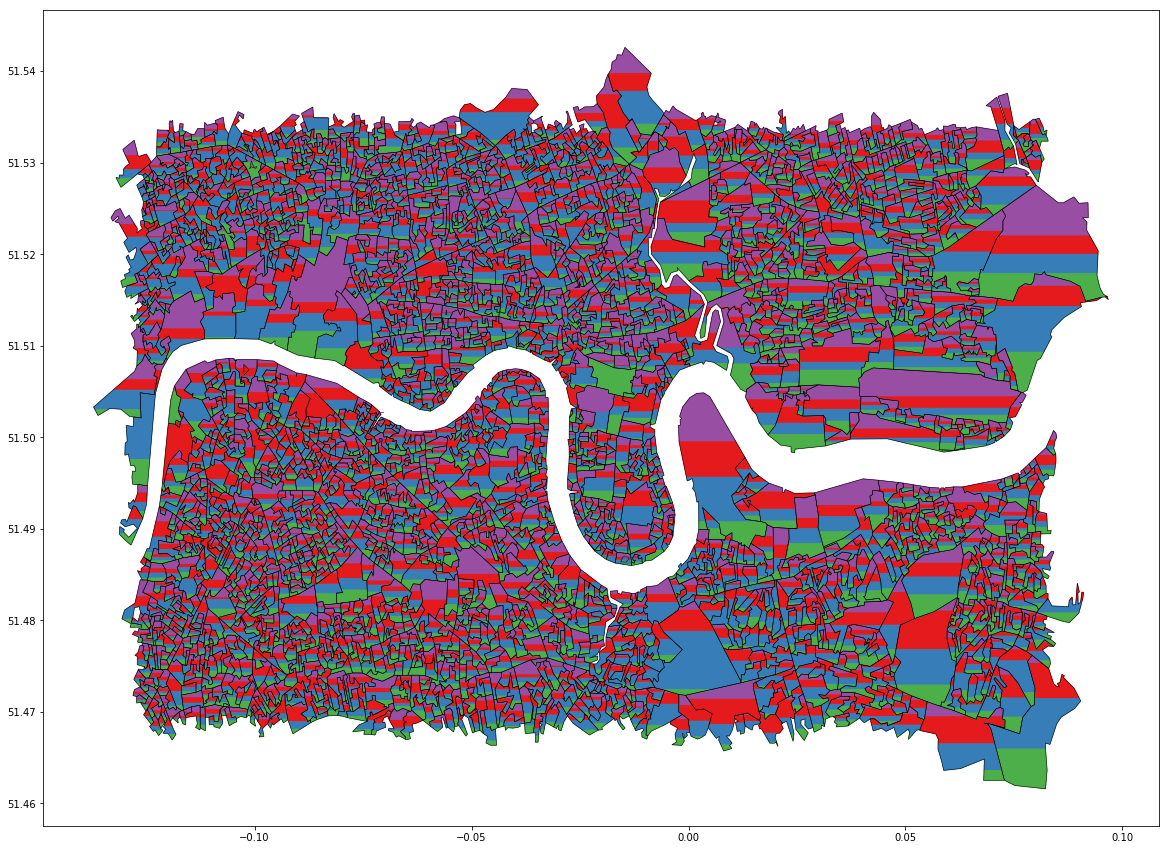

In [4]:
### example
plot_map(poly, ['eat_lu','health_lu','edu_lu','leisure_lu'])